In [2]:
import cv2
import glob
import numpy as np
from IPython.display import Image

# Task 2



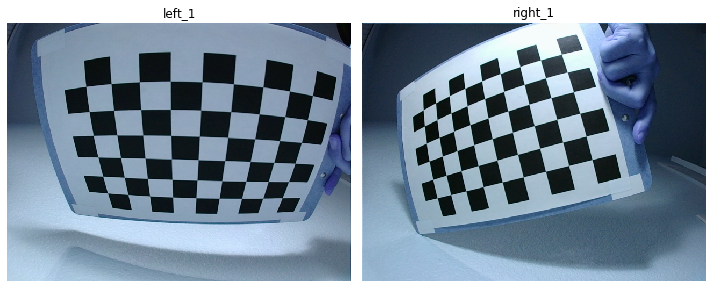

In [3]:
left_ = [cv2.imread(image) for image in glob.glob("../../images/task_1/left_*.png")]
right_ = [cv2.imread(image) for image in glob.glob("../../images/task_1/right_*.png")]

import matplotlib.pyplot as plt
def plot_figures(figures, nrows=1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10,10))
    if(nrows > 1 or ncols > 1):
        for ind,title in enumerate(figures):
            axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
            axeslist.ravel()[ind].set_title(title)
            axeslist.ravel()[ind].set_axis_off()
        plt.tight_layout() # optional
    else:
        for ind,title in enumerate(figures):
            axeslist.imshow(figures[title], cmap=plt.gray())
            axeslist.set_title(title)
            axeslist.set_axis_off()
            

plot_figures({'left_1': left_[0], 'right_1': right_[0]}, 1, 2)

In [4]:
s = cv2.FileStorage('../task_1/calibrated_camera_parameters.xml', cv2.FileStorage_READ)

In [5]:
s.isOpened()

True

In [6]:
mtx = s.getNode('mtx').mat()
dist = s.getNode('dist').mat()
newcameramtx = s.getNode('newcameramtx').mat()
roi = s.getNode('roi').mat()
roi

array([[144.],
       [131.],
       [467.],
       [302.]])

In [7]:
dist

array([[-0.47346982,  0.25329524, -0.00219312,  0.00187598, -0.05224572]])

# Step (2): Extract 3D-to-2D point correspondences :

This is the same as task 1 step (2). The only difference is that in this task there are two sets of 2D points for both cameras. The 3D points are the same as those in task 1 step (2).


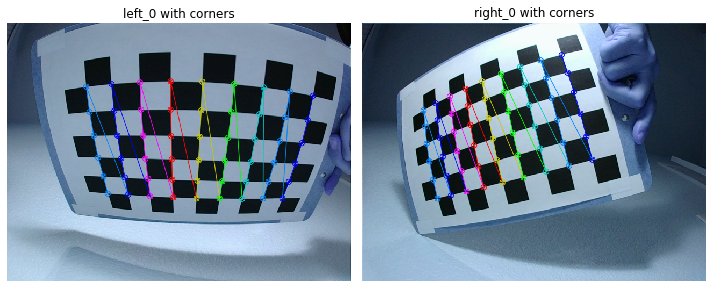

In [8]:
retval_left, corners_2D_left = cv2.findChessboardCorners(left_[0],(6,9))
# print(retval,corners_2D)

corner_img_left = left_[0].copy()
corner_img_left = cv2.drawChessboardCorners(corner_img_left,(6,9),corners_2D_left,retval_left)
#plot_figures({'left_0 with corners': corner_img_left})

retval_right, corners_2D_right = cv2.findChessboardCorners(right_[0],(6,9))
# print(retval,corners_2D)

corner_img_right = right_[0].copy()
corner_img_right = cv2.drawChessboardCorners(corner_img_right,(6,9),corners_2D_right,retval_right)
plot_figures({'left_0 with corners': corner_img_left, 'right_0 with corners': corner_img_right}, 1, 2)



# Step (3): Calibrate the stereo camera :
Once the 3D-to-2D point correspondences are obtained, call OpenCV library function "stereoCalibrate()" to calculate the parameters between the two views, including the translation, rotation, the fundamental matrix, and the essential matrix. Note that the "CALIB_FIX_INTRINSIC" flag should be set and the camera intrinsics should be provided when you call the stereo calibration library function.

## calibrateCamera():

C++: double calibrateCamera(InputArrayOfArrays objectPoints, InputArrayOfArrays imagePoints, Size imageSize, InputOutputArray cameraMatrix, InputOutputArray distCoeffs, OutputArrayOfArrays rvecs, OutputArrayOfArrays tvecs, int flags=0, TermCriteria criteria=TermCriteria( TermCriteria::COUNT+TermCriteria::EPS, 30, DBL_EPSILON) )

Python: cv2.calibrateCamera(objectPoints, imagePoints, imageSize[, cameraMatrix[, distCoeffs[, rvecs[, tvecs[, flags[, criteria]]]]]]) → retval, cameraMatrix, distCoeffs, rvecs, tvecs¶

## stereoCalibrate():

C++: double stereoCalibrate(InputArrayOfArrays objectPoints, InputArrayOfArrays imagePoints1, InputArrayOfArrays imagePoints2, InputOutputArray cameraMatrix1, InputOutputArray distCoeffs1, InputOutputArray cameraMatrix2, InputOutputArray distCoeffs2, Size imageSize, OutputArray R, OutputArray T, OutputArray E, OutputArray F, TermCriteria criteria=TermCriteria(TermCriteria::COUNT+TermCriteria::EPS, 30, 1e-6), int flags=CALIB_FIX_INTRINSIC )

Python: cv2.stereoCalibrate(objectPoints, imagePoints1, imagePoints2, imageSize[, cameraMatrix1[, distCoeffs1[, cameraMatrix2[, distCoeffs2[, R[, T[, E[, F[, criteria[, flags]]]]]]]]]]) → retval, cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, R, T, E, F











In [13]:
###this is for the left image##

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

rows = 6
columns = 7   # only works with at most 7
# columns = 8
# columns = 9

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(columns,5,0)
objp = np.zeros((columns*rows,3), np.float32)
objp[:,:2] = np.mgrid[0:columns,0:rows].T.reshape(-1,2)





# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.



#images = left_ + right_

for img in left_:

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (columns,rows),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (columns,rows), corners2,ret)
        plot_figures({'left:':img},1)

        

print("obj points (left):\n",objpoints)

obj points (left):
 []


In [12]:
###this is for the right image##


# termination criteria
criteria1 = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

rows1 = 6
columns1 = 7   # only works with at most 7
# columns = 8
# columns = 9

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(columns,5,0)
objp1 = np.zeros((columns1*rows1,3), np.float32)
objp1[:,:2] = np.mgrid[0:columns1,0:rows1].T.reshape(-1,2)



# Arrays to store object points and image points from all the images.
objpoints1 = [] # 3d point in real world space
imgpoints1 = [] # 2d points in image plane.




#images = left_ + right_

for img1 in right_:

    gray1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret1, corners1 = cv2.findChessboardCorners(gray1, (columns1,rows1),None)

    # If found, add object points, image points (after refining them)
    if ret1 == True:
        objpoints1.append(objp1)

        corners21 = cv2.cornerSubPix(gray1,corners1,(11,11),(-1,-1),criteria1)
        imgpoints1.append(corners21)

        # Draw and display the corners
        img1 = cv2.drawChessboardCorners(img1, (columns1,rows1), corners21,ret1)
        plt.imshow(img1)


print("obj points (right):\n",objpoints)

obj points (right):
 [array([[0., 0., 0.],
       [1., 0., 0.],
       [2., 0., 0.],
       [3., 0., 0.],
       [4., 0., 0.],
       [5., 0., 0.],
       [6., 0., 0.],
       [0., 1., 0.],
       [1., 1., 0.],
       [2., 1., 0.],
       [3., 1., 0.],
       [4., 1., 0.],
       [5., 1., 0.],
       [6., 1., 0.],
       [0., 2., 0.],
       [1., 2., 0.],
       [2., 2., 0.],
       [3., 2., 0.],
       [4., 2., 0.],
       [5., 2., 0.],
       [6., 2., 0.],
       [0., 3., 0.],
       [1., 3., 0.],
       [2., 3., 0.],
       [3., 3., 0.],
       [4., 3., 0.],
       [5., 3., 0.],
       [6., 3., 0.],
       [0., 4., 0.],
       [1., 4., 0.],
       [2., 4., 0.],
       [3., 4., 0.],
       [4., 4., 0.],
       [5., 4., 0.],
       [6., 4., 0.],
       [0., 5., 0.],
       [1., 5., 0.],
       [2., 5., 0.],
       [3., 5., 0.],
       [4., 5., 0.],
       [5., 5., 0.],
       [6., 5., 0.]], dtype=float32)]
